### Dataframe setup

In [2]:
import pandas as pd

df = pd.read_csv('./datasets/filtered_data.csv')
df

,patient_id,gender,age,race,ESR1,PGR,ERBB2,subtype
0,TCGA-E2-A1IU,female,60,white,Positive,Positive,Negative,Luminal A
1,TCGA-A2-A04W,female,50,white,Negative,Negative,Positive,HER2-enriched
2,TCGA-A7-A26E,female,71,white,Positive,Positive,Negative,Luminal A
3,TCGA-A8-A07W,female,76,not reported,Positive,Positive,Negative,Luminal A
4,TCGA-D8-A1XY,female,74,white,Positive,Positive,Positive,Luminal B
...,...,...,...,...,...,...,...,...
777,TCGA-D8-A147,female,45,white,Negative,Negative,Negative,Triple Negative
778,TCGA-B6-A40C,female,51,white,Positive,Positive,Negative,Luminal A
779,TCGA-A2-A0CP,female,60,white,Positive,Positive,Negative,Luminal A
780,TCGA-A2-A3XZ,female,46,black or african american,Negative,Negative,Positive,HER2-enriched


### Preprocessing

In [3]:
from sklearn.preprocessing import LabelEncoder

df = df.drop(columns=['patient_id'])

categorical_cols = ['gender', 'race', 'ESR1', 'PGR', 'ERBB2']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder if needed later


# Encode the target variable (subtype)
target_encoder = LabelEncoder()
df['subtype_encoded'] = target_encoder.fit_transform(df['subtype'])

# Split features and labels
X = df.drop(columns=['subtype_encoded'])
y = df['subtype_encoded']

### Export Preprocessed Data

In [4]:
df.to_csv('./datasets/preprocessed_data.csv', index=False)

import pickle

with open('./datasets/subtype_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

### Load Data

In [5]:
# Load preprocessed data
df = pd.read_csv('./datasets/preprocessed_data.csv')

# Load label encoder
with open('./datasets/subtype_encoder.pkl', 'rb') as f:
    target_encoder = pickle.load(f)

df

,gender,age,race,ESR1,PGR,ERBB2,subtype,subtype_encoded
0,0,60,4,2,1,0,Luminal A,1
1,0,50,4,1,0,1,HER2-enriched,0
2,0,71,4,2,1,0,Luminal A,1
3,0,76,3,2,1,0,Luminal A,1
4,0,74,4,2,1,1,Luminal B,2
...,...,...,...,...,...,...,...,...
777,0,45,4,1,0,0,Triple Negative,3
778,0,51,4,2,1,0,Luminal A,1
779,0,60,4,2,1,0,Luminal A,1
780,0,46,2,1,0,1,HER2-enriched,0


### Train model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

df = df.drop(columns=['subtype'])
# Split features (X) and target (y)
X = df.drop(columns=['subtype_encoded'])
y = df['subtype_encoded']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()

# Train models
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

# Predict
rf_preds = rf.predict(X_test)
knn_preds = knn.predict(X_test)

# Evaluate
print("=== Random Forest ===")
print(classification_report(y_test, rf_preds, target_names=target_encoder.classes_))

print("=== K-Nearest Neighbors ===")
print(classification_report(y_test, knn_preds, target_names=target_encoder.classes_))

=== Random Forest ===
                 precision    recall  f1-score   support

  HER2-enriched       1.00      1.00      1.00         9
      Luminal A       1.00      1.00      1.00        99
      Luminal B       1.00      1.00      1.00        21
Triple Negative       1.00      1.00      1.00        28

       accuracy                           1.00       157
      macro avg       1.00      1.00      1.00       157
   weighted avg       1.00      1.00      1.00       157

=== K-Nearest Neighbors ===
                 precision    recall  f1-score   support

  HER2-enriched       0.00      0.00      0.00         9
      Luminal A       0.86      0.99      0.92        99
      Luminal B       0.75      0.57      0.65        21
Triple Negative       0.81      0.79      0.80        28

       accuracy                           0.84       157
      macro avg       0.61      0.59      0.59       157
   weighted avg       0.79      0.84      0.81       157



c:\Users\parwe\Documents\MinorAi\CapstoneProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\parwe\Documents\MinorAi\CapstoneProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\parwe\Documents\MinorAi\CapstoneProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Cross-Validation and Metrics

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVC (Linear)': SVC(kernel='linear'),
    'SVC (RBF)': SVC(kernel='rbf')
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    print(f"{name} - F1 (weighted) CV score: {scores.mean():.4f} (+/- {scores.std():.4f})")

Random Forest - F1 (weighted) CV score: 0.9987 (+/- 0.0025)
K-Nearest Neighbors - F1 (weighted) CV score: 0.7806 (+/- 0.0329)
Logistic Regression - F1 (weighted) CV score: 0.9987 (+/- 0.0025)
SVC (Linear) - F1 (weighted) CV score: 0.9987 (+/- 0.0025)
SVC (RBF) - F1 (weighted) CV score: 0.4342 (+/- 0.0030)


### Hyperparameter Tuning

In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize base model
rf = RandomForestClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_weighted',
                           n_jobs=-1,
                           verbose=1)

# Run the grid search
grid_search.fit(X, y)

# Show best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 (weighted):", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best F1 (weighted): 0.9987440010969422


### Final Prediction

In [9]:
# Final model (already fitted during GridSearchCV)
best_model = grid_search.best_estimator_

# Predict on the full feature set
y_pred = best_model.predict(X)

# Optional: Evaluate how well it fits the entire dataset
from sklearn.metrics import classification_report

print(classification_report(y, y_pred, target_names=target_encoder.classes_))

                 precision    recall  f1-score   support

  HER2-enriched       0.97      1.00      0.99        39
      Luminal A       1.00      1.00      1.00       459
      Luminal B       1.00      0.99      1.00       137
Triple Negative       1.00      1.00      1.00       147

       accuracy                           1.00       782
      macro avg       0.99      1.00      1.00       782
   weighted avg       1.00      1.00      1.00       782



### Feature Importance Plot

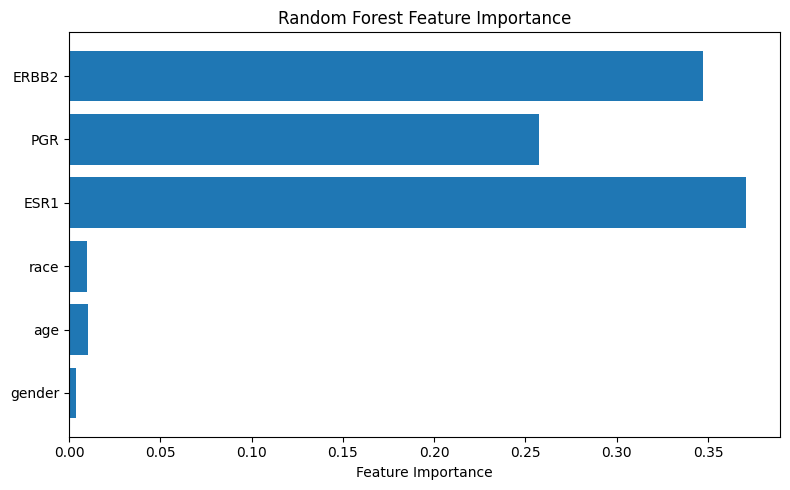

In [10]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


### Export Trained Model and Encoders

In [12]:
import pickle

# Save model
with open('./models/trained_rf_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the subtype encoder
with open('./models/subtype_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

# Save feature encoders if needed
with open('./models/feature_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)  # From earlier preprocessing

### Reload model

In [13]:
with open('./models/trained_rf_model.pkl', 'rb') as f:
    model = pickle.load(f)

### Testing

#### Internal Testing

In [15]:
# Predict a few examples (e.g., first 5)
X_test_sample = X.iloc[:5]
y_pred = best_model.predict(X_test_sample)

# Decode predictions
decoded_preds = target_encoder.inverse_transform(y_pred)
print("Sample:", X_test_sample)
print("Predicted subtypes:", decoded_preds)


Sample:    gender  age  race  ESR1  PGR  ERBB2
0       0   60     4     2    1      0
1       0   50     4     1    0      1
2       0   71     4     2    1      0
3       0   76     3     2    1      0
4       0   74     4     2    1      1
Predicted subtypes: ['Luminal A' 'HER2-enriched' 'Luminal A' 'Luminal A' 'Luminal B']


#### External Testing

In [16]:
new_patient = pd.DataFrame([{
    'gender': label_encoders['gender'].transform(['female'])[0],
    'age': 55,
    'race': label_encoders['race'].transform(['white'])[0],
    'ESR1': label_encoders['ESR1'].transform(['Positive'])[0],
    'PGR': label_encoders['PGR'].transform(['Positive'])[0],
    'ERBB2': label_encoders['ERBB2'].transform(['Negative'])[0]
}])


# Predict
pred = best_model.predict(new_patient)
pred_label = target_encoder.inverse_transform(pred)
print("Patient data:" , new_patient)
print("Predicted Subtype:", pred_label[0])

Patient data:    gender  age  race  ESR1  PGR  ERBB2
0       0   55     4     2    1      0
Predicted Subtype: Luminal A
